RNN implementation from Scratch

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
data = pd.read_csv('/content/GOOGL.csv', index_col='Date', parse_dates=True, dayfirst=True)

Selecting the required column from the data

In [ ]:
data = data.reset_index()
data = data[["Date", "Open", "High", "Low", "Volume"]]
data = data.set_index("Date")

In [ ]:
data.head()

,Open,High,Low,Volume
Date,,,,
2004-08-19,50.050049,52.082081,48.028027,44659096
2004-08-20,50.555557,54.594597,50.300301,22834343
2004-08-23,55.430431,56.796799,54.579578,18256126
2004-08-24,55.675674,55.855858,51.836838,15247337
2004-08-25,52.532532,54.054054,51.991993,9188602


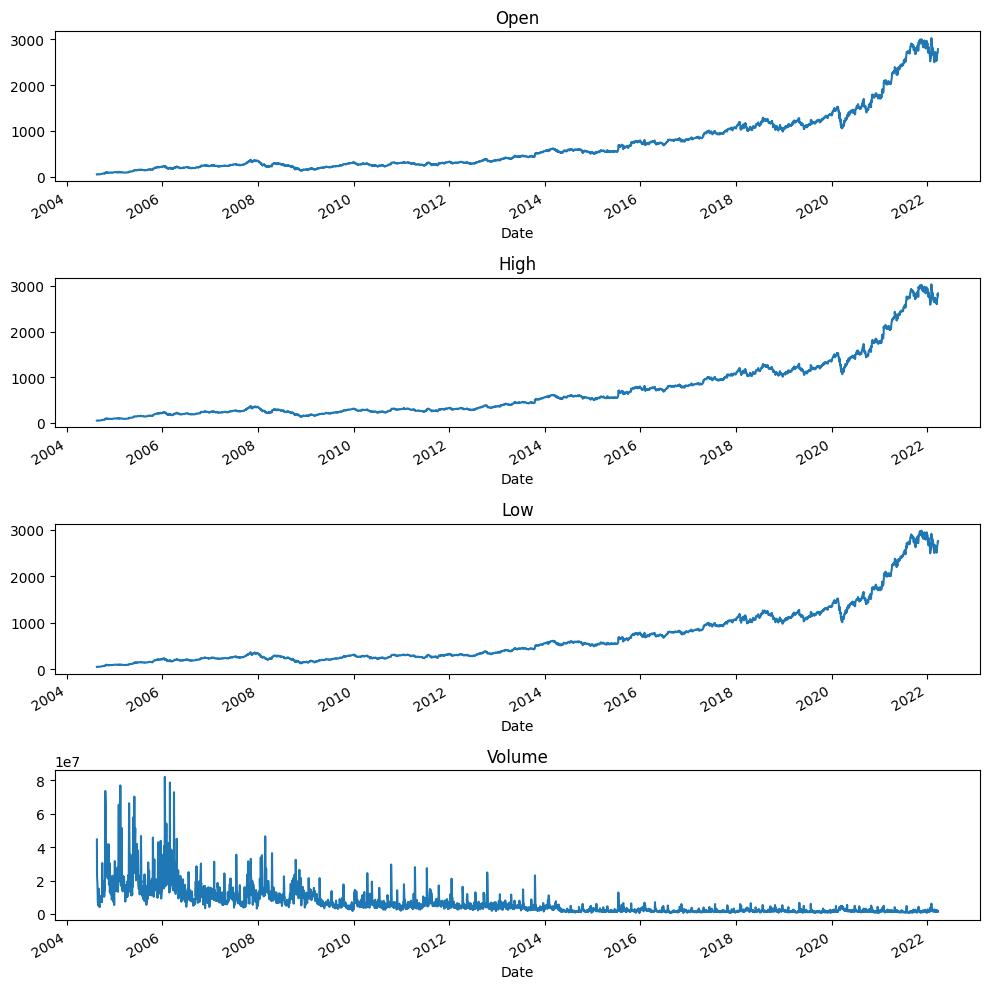

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# Plot each column in a separate subplot
data["Open"].plot(ax=axs[0], title="Open")
data["High"].plot(ax=axs[1], title="High")
data["Low"].plot(ax=axs[2], title="Low")
data["Volume"].plot(ax=axs[3], title="Volume")

plt.tight_layout()
plt.show()

In [ ]:
df = data

Adding missing dates in data

In [ ]:
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')
date_range = pd.date_range(start=df.index.min(), end=df.index.max())
df = df.reindex(date_range)

# Fill missing values using forward fill
df.fillna(method='ffill', inplace=True)

Separating data for training and testing

In [ ]:
train = df.loc[df.index < '2021-01-01']
test = df.loc[df.index >= '2021-01-01']

Normalising the data

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Implementation of RNN model from scratch

In [ ]:
class RNN:

    def __init__(self, x, y, hidden_units):
        self.x = x # shape [samples, timesteps, features]
        self.y = y # shape [samples, outputs]
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(self.hidden_units, self.x.shape[2])
        self.Wh = np.random.randn(self.hidden_units, self.hidden_units)
        self.Wy = np.random.randn(self.y.shape[1],self.hidden_units)

    def cell(self, xt, ht_1):
        ht = np.tanh(np.dot(self.Wx,xt.reshape(1,1)) + np.dot(self.Wh,ht_1))
        yt = np.dot(self.Wy,ht)
        return ht, yt

    def forward(self, sample):
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((self.hidden_units,1)) # first hidden state is zeros vector
        self.hidden_states = [ht] # collection of hidden states for each sample
        self.inputs = [] # collection of inputs for each sample
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step],ht)
            self.inputs.append(sample_x[step].reshape(1,1))
            self.hidden_states.append(ht)
        self.error = yt - sample_y
        self.loss = 0.5*self.error**2
        self.yt = yt

    def backward(self):
        n = len(self.inputs)
        dyt = self.error # dL/dyt
        dWy = np.dot(dyt,self.hidden_states[-1].T) # dyt/dWy
        dht = np.dot(dyt, self.Wy).T # dL/dht = dL/dyt * dyt/dht ,where ht = tanh(Wx*xt + Wh*ht))
        dWx = np.zeros(self.Wx.shape)
        dWh = np.zeros(self.Wh.shape)
        # BPTT
        for step in reversed(range(n)):
            temp = (1-self.hidden_states[step+1]**2) * dht # dL/dtanh = dL/dyt * dyt/dht * dht/dtanh, where dtanh = (1-ht**2)
            dWx += np.dot(temp, self.inputs[step].T) # dL/dWx = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWx
            dWh += np.dot(temp, self.hidden_states[step].T) # dL/dWh = dL/dyt * dyt/dht * dht/dtanh * dtanh/dWh

            dht = np.dot(self.Wh, temp) # dL/dht-1 = dL/dht * (1 - ht+1^2) * Whh
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh

    def train(self, epochs, learning_rate):
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in tqdm(range(epochs)):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            self.Ovr_loss.append(np.squeeze(self.loss / self.x.shape[0]))
            self.loss = 0

    def test(self,x,y):
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)

Code for training and testing "Open", "High", "Low", "Volume"

100%|██████████| 60/60 [01:07<00:00,  1.12s/it]


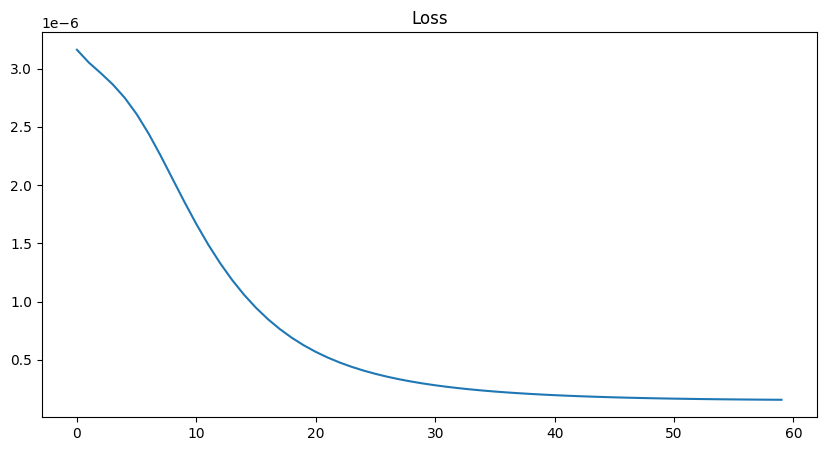

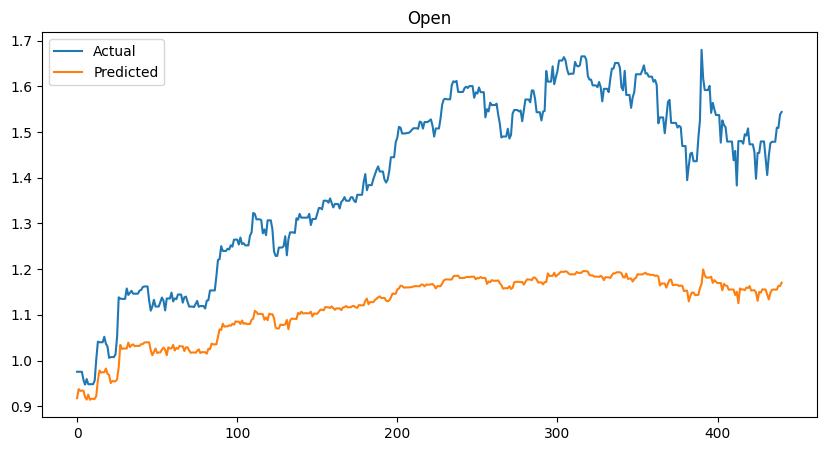

100%|██████████| 60/60 [00:56<00:00,  1.06it/s]


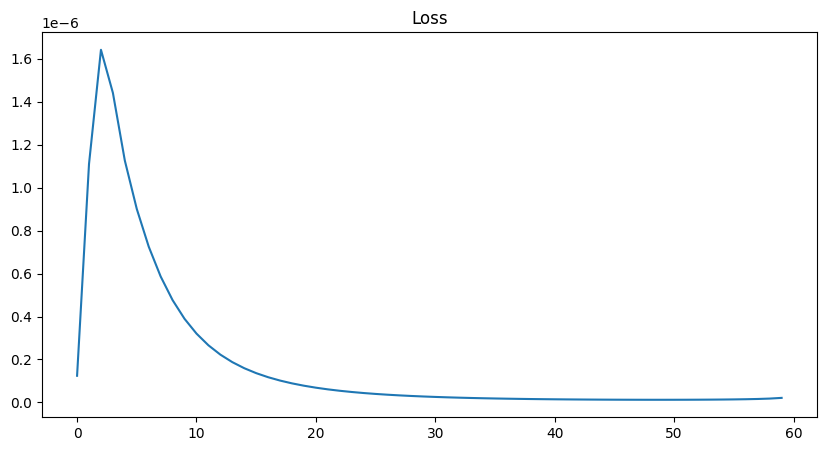

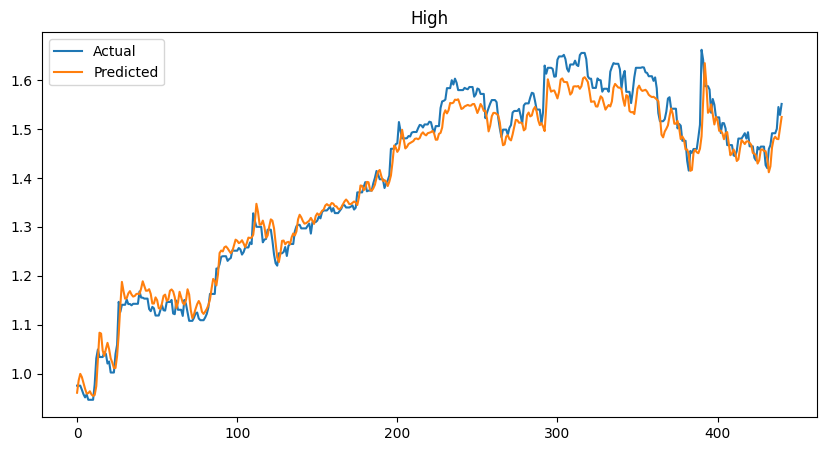

100%|██████████| 60/60 [00:56<00:00,  1.07it/s]


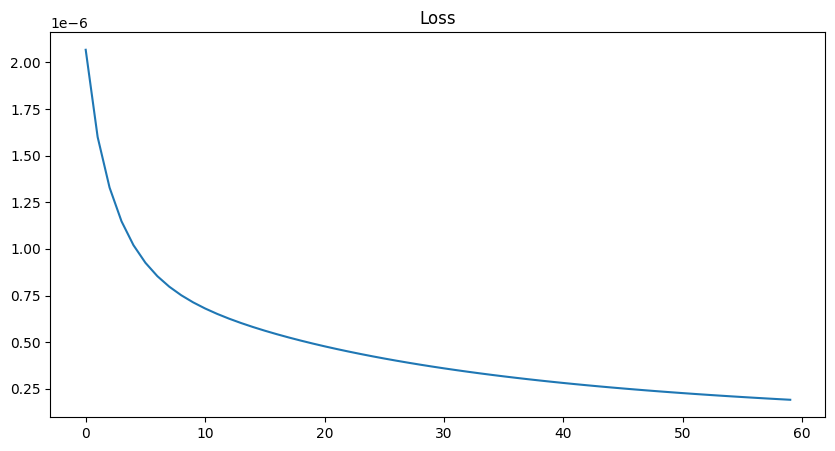

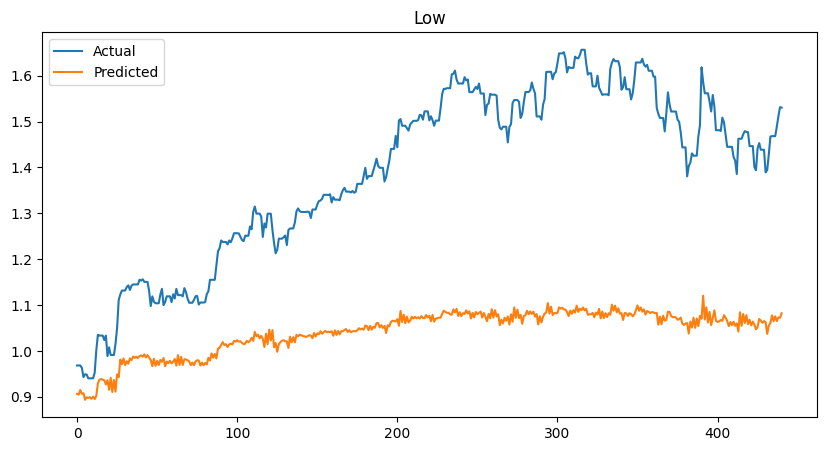

100%|██████████| 60/60 [00:56<00:00,  1.07it/s]


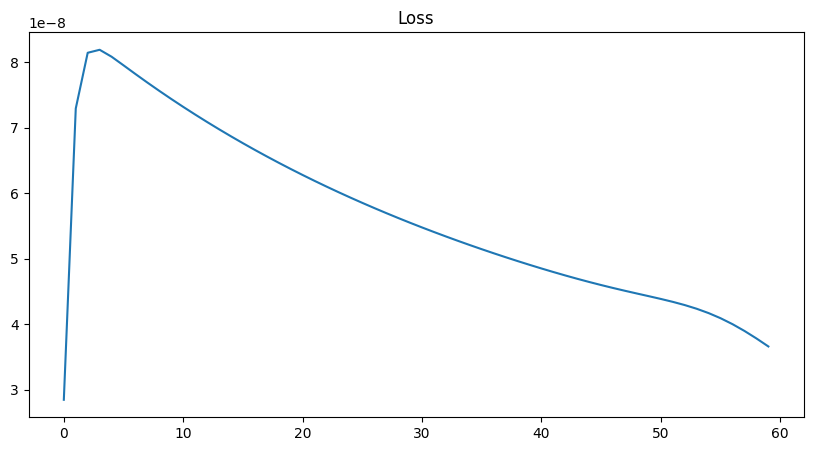

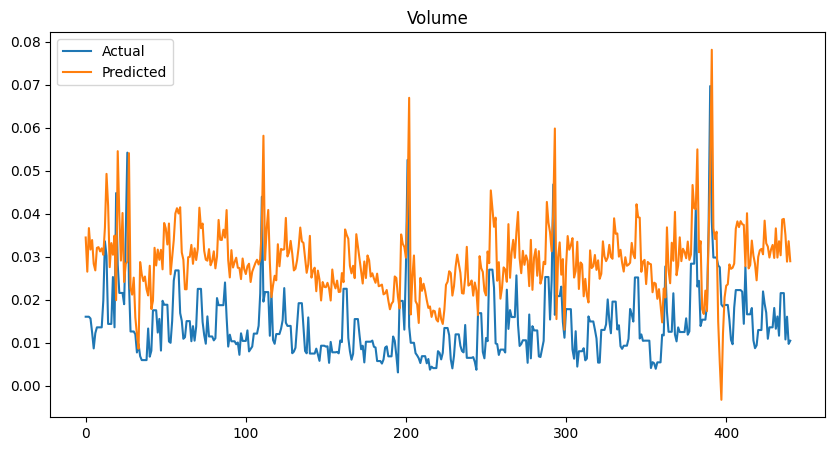

In [ ]:
rmse = []
# timesteps = 5
for i in range(4):
  x, y = [], []

  timesteps = 7
  for step in range(5970-timesteps):
      x.append(scaled_train[step:step+timesteps][:,i])
      y.append(scaled_train[step+timesteps][i])
  # print(np.shape(np.array(x)))
  # print(np.shape(np.array(y)))
  x = np.array(x).reshape(len(y),timesteps,1)
  y = np.array(y).reshape(len(y),1)

  rnn = RNN(x,y,3)
  rnn.train(60,1e-3)

  timesteps = 7
  x_test, y_test = [], []

  for step in range(448 - timesteps):
      x_test.append(scaled_test[step:step + timesteps][:,i])
      y_test.append(scaled_test[step + timesteps][i])

  x_test = np.array(x_test).reshape(len(y_test), timesteps, 1)
  y_test = np.array(y_test).reshape(len(y_test), 1)


  rnn.test(x_test, y_test)
  rmse.append(sqrt(mean_squared_error(y_test, np.array(rnn.outputs).reshape(y_test.shape))))

  plt.figure(figsize=(10, 5))
  plt.plot(rnn.Ovr_loss)
  plt.title("Loss")
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot([i for i in range(len(x_test))], y_test, label='Actual')
  plt.plot([i for i in range(len(x_test))], np.array(rnn.outputs)[:, 0], label='Predicted')
  plt.legend()
  plt.title(["Open", "High", "Low", "Volume"][i])
  plt.show()

RMSE error metric and observe that loss is decreasing in all plots

In [ ]:
for i in range(4):
  print(f"RMSE for {['Open', 'High', 'Low', 'Volume'][i]}: {rmse[i]}")

RMSE for Open: 0.30750076384430036
RMSE for High: 0.03129082412728004
RMSE for Low: 0.3764583722703004
RMSE for Volume: 0.016859369452694145


RNN implementation using libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
google_stock_data = pd.read_csv('/content/GOOGL.csv')
google_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,19-08-2004,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,20-08-2004,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,23-08-2004,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,24-08-2004,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,25-08-2004,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


Selecting the required columns from the data

In [ ]:
google_stock_data = google_stock_data[['Date','Open','High','Low','Volume']]
google_stock_data['Date'] = pd.to_datetime(google_stock_data['Date'].apply(lambda x: x.split()[0]))
google_stock_data.set_index('Date',drop=True,inplace=True)
google_stock_data.head()

<ipython-input-3-d0621ce71bb3>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  google_stock_data['Date'] = pd.to_datetime(google_stock_data['Date'].apply(lambda x: x.split()[0]))


,Open,High,Low,Volume
Date,,,,
2004-08-19,50.050049,52.082081,48.028027,44659096
2004-08-20,50.555557,54.594597,50.300301,22834343
2004-08-23,55.430431,56.796799,54.579578,18256126
2004-08-24,55.675674,55.855858,51.836838,15247337
2004-08-25,52.532532,54.054054,51.991993,9188602


Normalising the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
google_stock_data[google_stock_data.columns] = MMS.fit_transform(google_stock_data)

In [ ]:
google_stock_data.shape

(4431, 4)

Dividing the data for testing and training

In [ ]:
train_data = google_stock_data.loc[google_stock_data.index < '2021-01-01']
test_data  = google_stock_data.loc[google_stock_data.index >= '2021-01-01']

train_data.shape, test_data.shape

((4122, 4), (309, 4))

For generating sequence of data for LSTM Model

In [ ]:
def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [ ]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [ ]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((4072, 50, 4), (4072, 4), (259, 50, 4), (259, 4))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

Model Architecture

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1))
model.add(LSTM(units=50))

model.add(Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            11000     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 31404 (122.67 KB)
Trainable params: 31404 (122.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Observe that loss is decreasing with epochs

In [ ]:
model.fit(train_seq, train_label, epochs=70,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/70
128/128 [==============================] - 27s 132ms/step - loss: 0.0024 - mean_absolute_error: 0.0237 - val_loss: 0.0038 - val_mean_absolute_error: 0.0519
Epoch 2/70
128/128 [==============================] - 7s 57ms/step - loss: 8.2559e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0057 - val_mean_absolute_error: 0.0698
Epoch 3/70
128/128 [==============================] - 6s 49ms/step - loss: 8.3676e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0045 - val_mean_absolute_error: 0.0597
Epoch 4/70
128/128 [==============================] - 7s 54ms/step - loss: 8.2122e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0034 - val_mean_absolute_error: 0.0492
Epoch 5/70
128/128 [==============================] - 7s 53ms/step - loss: 7.8846e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0031 - val_mean_absolute_error: 0.0496
Epoch 6/70
128/128 [==============================] - 7s 51ms/step - loss: 7.7297e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0019 - val_mean_absolute_er

In [ ]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

9/9 [==============================] - 2s 16ms/step


array([[0.6896088 , 0.68873686, 0.6820208 , 0.02259333],
       [0.6906689 , 0.6895574 , 0.6831326 , 0.02199943],
       [0.68344945, 0.6824295 , 0.6758541 , 0.02236672],
       [0.67514735, 0.6745374 , 0.66754407, 0.02362837],
       [0.67590314, 0.67554516, 0.6684466 , 0.02235245]], dtype=float32)

Inversing scaling

In [ ]:
test_inverse_predicted = MMS.inverse_transform(test_predicted)
test_inverse_predicted[:5]

array([[2.1014761e+03, 2.1033630e+03, 2.0463163e+03, 2.3111488e+06],
       [2.1046301e+03, 2.1058081e+03, 2.0495737e+03, 2.2626362e+06],
       [2.0831497e+03, 2.0845669e+03, 2.0282480e+03, 2.2926385e+06],
       [2.0584480e+03, 2.0610486e+03, 2.0039001e+03, 2.3956968e+06],
       [2.0606968e+03, 2.0640515e+03, 2.0065446e+03, 2.2914725e+06]],
      dtype=float32)

In [ ]:
predicted_data = pd.DataFrame(test_inverse_predicted, columns=['open_predicted', 'high_predicted', 'low_predicted','volume_predicted'], index=google_stock_data.index[-len(test_inverse_predicted):])
gs_slic_data = pd.concat([google_stock_data.iloc[-len(test_inverse_predicted):].copy(), predicted_data], axis=1)


In [ ]:
gs_slic_data[['Open','High','Low','Volume']] = MMS.inverse_transform(gs_slic_data[['Open','High','Low','Volume']])

In [ ]:
gs_slic_data.head()

,Open,High,Low,Volume,open_predicted,high_predicted,low_predicted,volume_predicted
Date,,,,,,,,
2021-03-17,2068.469971,2099.000000,2044.119995,1319100.0,2101.476074,2103.363037,2046.316284,2311148.75
2021-03-18,2048.179932,2068.750000,2019.180054,1585000.0,2104.630127,2105.808105,2049.573730,2262636.25
2021-03-19,2029.729980,2037.040039,2002.930054,2303600.0,2083.149658,2084.566895,2028.248047,2292638.50
2021-03-22,2027.630005,2048.340088,2014.000000,1676800.0,2058.447998,2061.048584,2003.900146,2395696.75
2021-03-23,2039.949951,2064.110107,2028.000000,1425500.0,2060.696777,2064.051514,2006.544556,2291472.50


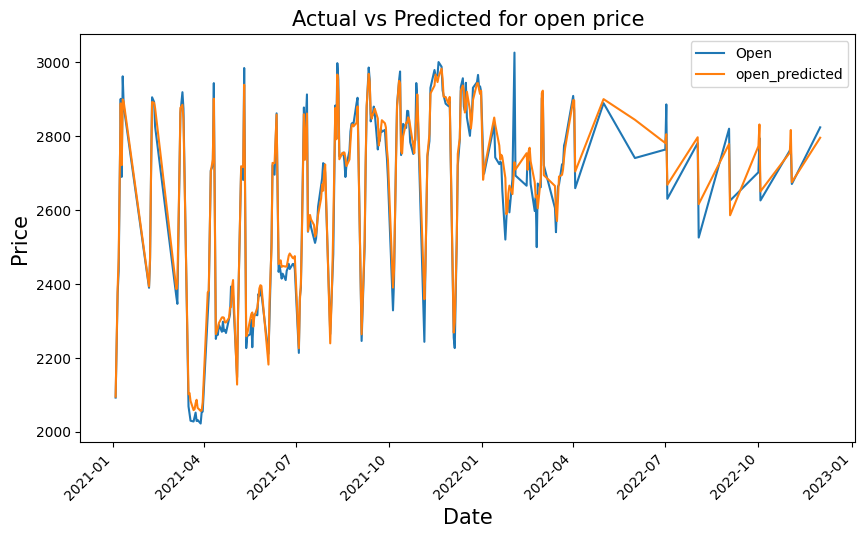

In [ ]:
gs_slic_data[['Open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

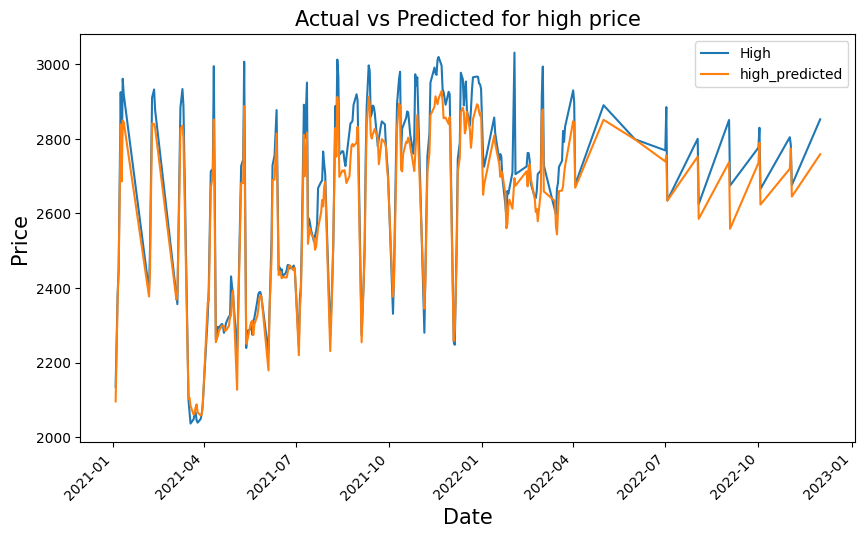

In [ ]:
gs_slic_data[['High','high_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.title('Actual vs Predicted for high price',size=15)
plt.show()

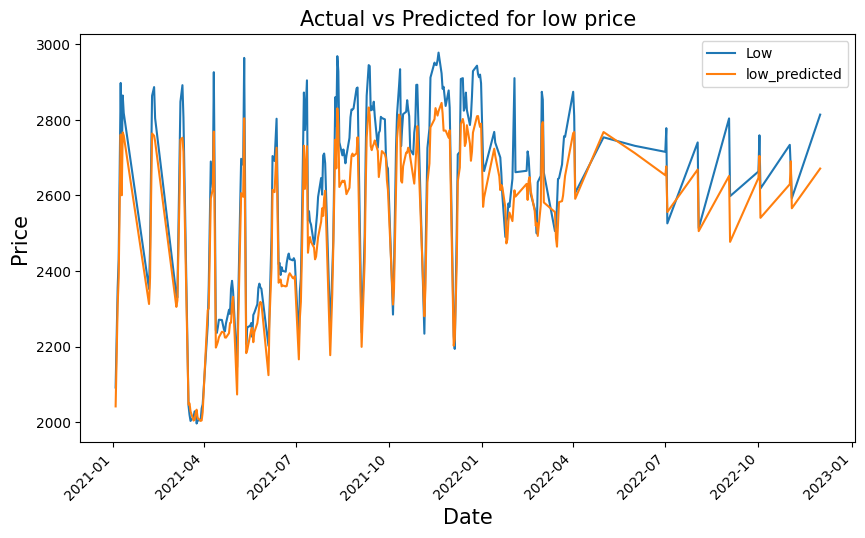

In [ ]:
gs_slic_data[['Low','low_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.title('Actual vs Predicted for low price',size=15)
plt.show()

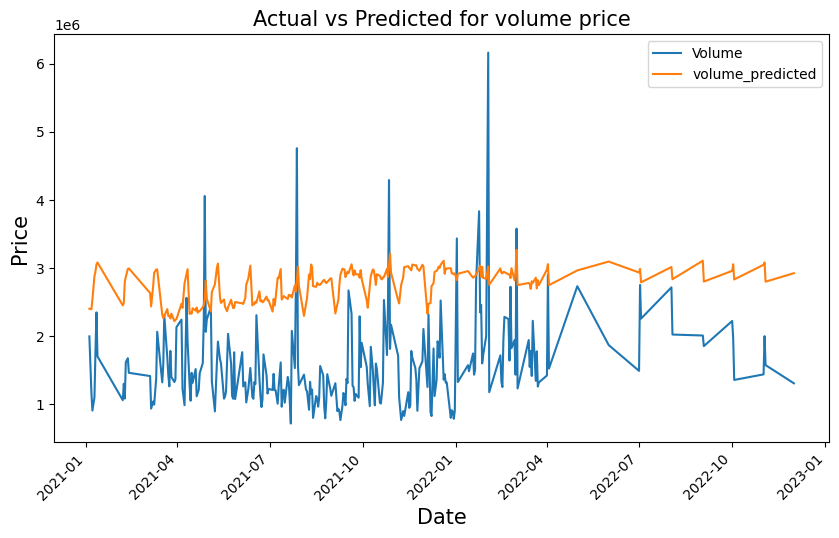

In [ ]:
gs_slic_data[['Volume','volume_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.title('Actual vs Predicted for volume price',size=15)
plt.show()